In [2]:
import nxarray
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dataset = nxarray.load("trARPES_T_150K_fl_0.786.nxs")

In [4]:
dataset

<xarray.Dataset>
Dimensions:                  (axis_angle: 198, axis_Energy: 298,
                              axis_pump_probe_delay: 70)
Coordinates:
  * axis_Energy              (axis_Energy) float32 -1.354 -1.342 ... 2.054 2.065
  * axis_angle               (axis_angle) float32 -13.15 -13.02 ... 13.98 14.12
  * axis_pump_probe_delay    (axis_pump_probe_delay) float64 -199.9 ... 4.997...
Data variables:
    Photoemission_intensity  (axis_angle, axis_Energy, axis_pump_probe_delay) float32 ...
Attributes:
    NXtree:   NeXus tree (9 objects).

In [5]:
data = dataset.Photoemission_intensity
data

<xarray.DataArray 'Photoemission_intensity' (axis_angle: 198, axis_Energy: 298,
                                             axis_pump_probe_delay: 70)>
array([[[1.815059e+06, 1.868277e+06, 1.805282e+06, ..., 1.933123e+06,
         1.762958e+06, 1.745426e+06],
        [1.791252e+06, 1.832731e+06, 1.773717e+06, ..., 1.899318e+06,
         1.754476e+06, 1.740931e+06],
        [1.791916e+06, 1.818197e+06, 1.742933e+06, ..., 1.861009e+06,
         1.730557e+06, 1.741606e+06],
        ...,
        [5.169916e+01, 1.574893e+02, 3.943390e+03, ..., 2.745910e+01,
         2.202493e+02, 6.998824e+01],
        [3.557920e+00, 2.937194e+02, 2.315262e+03, ..., 3.123223e+01,
         1.288288e+02, 0.000000e+00],
        [0.000000e+00, 2.548918e+02, 4.754717e+02, ..., 8.266313e+01,
         1.850058e+02, 1.095622e+03]],

       [[2.013107e+06, 2.031423e+06, 2.000440e+06, ..., 2.088373e+06,
         1.957752e+06, 1.978338e+06],
        [1.985372e+06, 1.998965e+06, 1.980877e+06, ..., 2.051626e+06,
         1.974618e+06, 1.936156e+06],
        [1.933536e+06, 1.963737e+06, 1.906350e+06, ..., 1.997309e+06,
         1.925682e+06, 1.902978e+06],
...
        [1.108587e+03, 1.424021e+03, 1.636932e+02, ..., 9.925690e+00,
         4.514138e+02, 1.774644e+03],
        [2.032496e+03, 2.961425e+02, 1.449014e+01, ..., 3.312166e+01,
         6.146954e+02, 1.810646e+03],
        [1.026904e+03, 1.670694e+02, 2.722634e+01, ..., 3.033728e+00,
         2.502937e+02, 7.631662e+02]],

       [[1.617966e+06, 1.635741e+06, 1.597857e+06, ..., 1.579500e+06,
         1.548884e+06, 1.635528e+06],
        [1.602070e+06, 1.589044e+06, 1.550704e+06, ..., 1.561454e+06,
         1.561631e+06, 1.598606e+06],
        [1.603073e+06, 1.558214e+06, 1.532240e+06, ..., 1.547622e+06,
         1.613926e+06, 1.578189e+06],
        ...,
        [1.689095e+01, 1.262053e+03, 2.724674e+02, ..., 5.672971e+01,
         4.000967e+02, 4.963677e+01],
        [0.000000e+00, 4.156810e+01, 3.158420e+01, ..., 1.436308e+02,
         3.951127e+02, 5.834339e+01],
        [1.485002e+02, 0.000000e+00, 8.211980e+01, ..., 1.465159e+01,
         1.693425e+02, 5.042321e+02]]], dtype=float32)
Coordinates:
  * axis_Energy            (axis_Energy) float32 -1.354 -1.342 ... 2.054 2.065
  * axis_angle             (axis_angle) float32 -13.15 -13.02 ... 13.98 14.12
  * axis_pump_probe_delay  (axis_pump_probe_delay) float64 -199.9 ... 4.997e+05
Attributes:
    nxgroup:  data

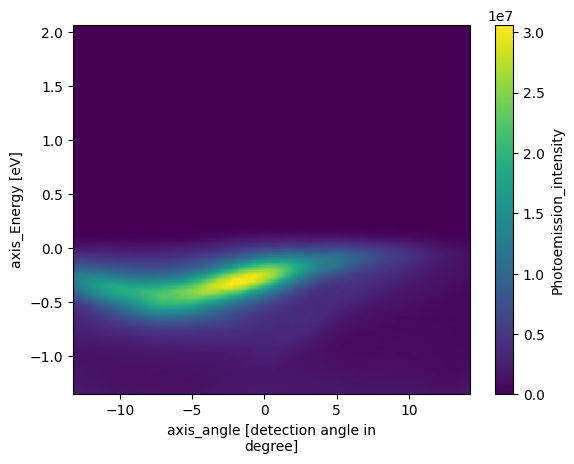

In [11]:
data_pret0 = data.loc[{"axis_pump_probe_delay": slice(-150, -50)}].mean(axis=2)
data_pret0.T.plot()

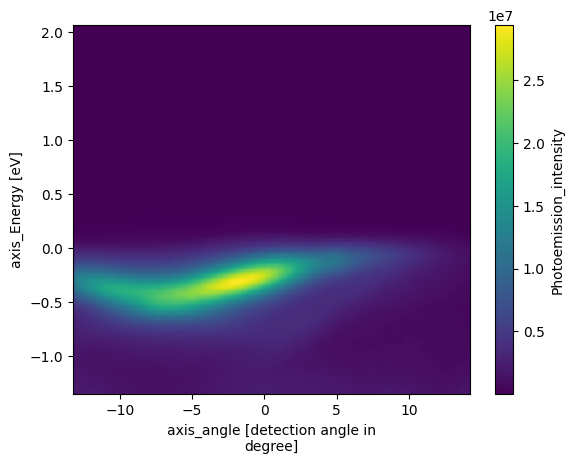

In [12]:
data_post0 = data.loc[{"axis_pump_probe_delay": slice(-50, 50)}].mean(axis=2)
data_post0.T.plot()

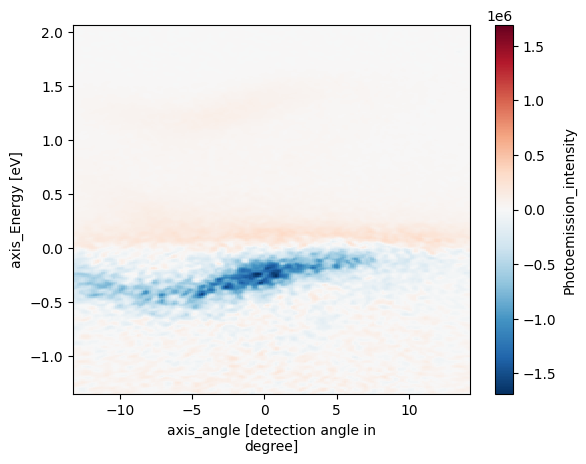

In [13]:
difference = data_post0 - data_pret0
difference.T.plot()

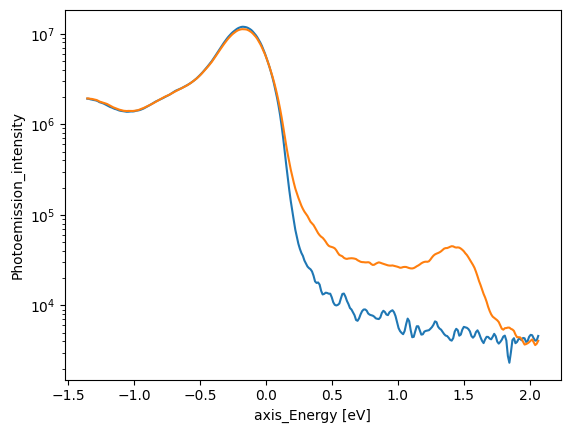

In [21]:
spectrum_pret0 = data_pret0.loc[{"axis_angle": slice(0, 10)}].mean(axis=0)
spectrum_post0 = data_post0.loc[{"axis_angle": slice(0, 10)}].mean(axis=0)
spectrum_pret0.plot()
spectrum_post0.plot()
plt.yscale('log')

In [51]:
from lmfit import Model
from lmfit import CompositeModel
def convolve(arr, kernel):
    """Simple convolution of two arrays."""
    npts = min(arr.size, kernel.size)
    pad = np.ones(npts)
    tmp = np.concatenate((pad*arr[0], arr, pad*arr[-1]))
    out = np.convolve(tmp, kernel, mode='valid')
    noff = int((len(out) - npts) / 2)
    return out[noff:noff+npts]

def gaussian(x, fwhm):
    """1-d gaussian: gaussian(x, wid)"""
    cen = x.mean()
    ret = np.exp(-(x-cen)**2 / (2*fwhm/2.3548200)**2)
    return ret/ret.sum()

def constant_fermi(x, mu, T, const):
    kb = 8.617E-5
    return const * 1/(np.exp((x-mu)/(kb*T))+1)

model = CompositeModel(Model(constant_fermi), Model(gaussian), convolve)

In [52]:
pars = model.make_params(const=10E7, mu=0, T=150, fwhm=.150)

In [57]:
pars["const"].set(value=1.2E7)
pars["T"].set(value=150)
pars["fwhm"].set(value=0.150)

c:\Users\lrettig\Documents\Python Scripts\venv\Lib\site-packages\xarray\core\computation.py:821: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


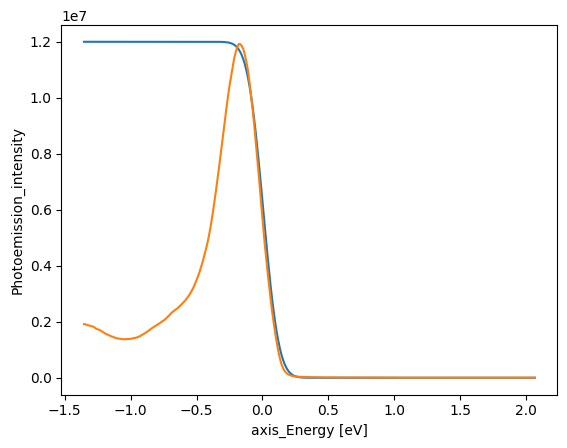

In [58]:
x = spectrum_pret0.axis_Energy
guess = model.eval(pars, x=x)
plt.plot(x, guess)
spectrum_pret0.plot()

In [59]:
pars["T"].set(value=150, vary=False)
pars

name,value,initial value,min,max,vary
mu,0.00000000,0.0,-inf,inf,True
T,150.000000,150,-inf,inf,False
const,12000000.0,12000000.0,-inf,inf,True
fwhm,0.15000000,0.15,-inf,inf,True


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 43
    # variables        = 3
    chi-square         = 3.2799e+11
    reduced chi-square = 8.1998e+09
    Akaike info crit   = 984.467187
    Bayesian info crit = 989.750787
    R-squared          = 0.99963263
[[Variables]]
    mu:    -0.00740754 +/- 8.3586e-04 (11.28%) (init = 0)
    T:      150 (fixed)
    const:  12365144.6 +/- 57078.9472 (0.46%) (init = 1.2e+07)
    fwhm:   0.14457785 +/- 0.00176953 (1.22%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, const)   = -0.8488
    C(const, fwhm) = +0.7478
    C(mu, fwhm)    = -0.6359


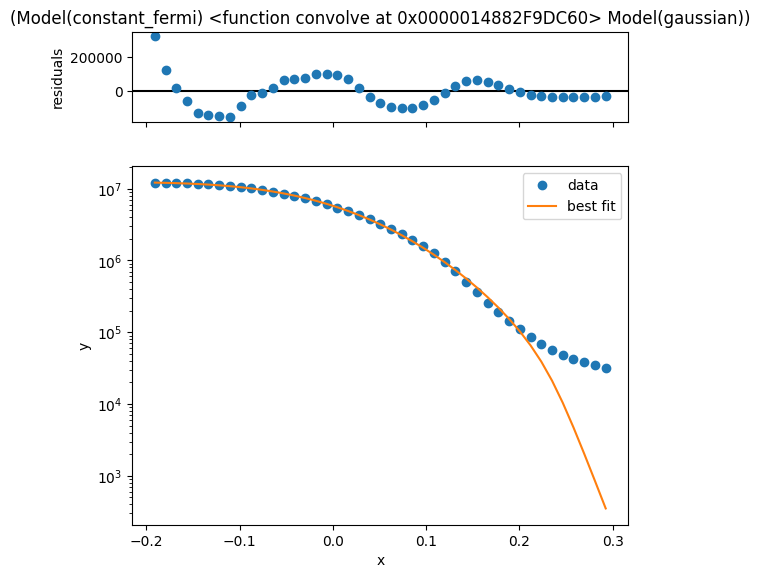

In [65]:
import lmfit
data_fit = spectrum_pret0.loc[{"axis_Energy": slice(-.2, .3)}]
result = model.fit(data_fit, params=pars, x=data_fit.axis_Energy)
lmfit.report_fit(result)
result.plot()
plt.yscale('log')

In [69]:
pars = pars.update(result.params)
pars["T"].set(vary=True)
pars["fwhm"].set(vary=False)
pars

name,value,standard error,relative error,initial value,min,max,vary
mu,-0.00740754,8.3586e-04,(11.28%),0.0,-inf,inf,True
T,150.000000,0.00000000,(0.00%),150,-inf,inf,True
const,12365144.6,57078.9472,(0.46%),12000000.0,-inf,inf,True
fwhm,0.14457785,0.00176953,(1.22%),0.15,-inf,inf,False


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 43
    # variables        = 3
    chi-square         = 3.2796e+11
    reduced chi-square = 8.1990e+09
    Akaike info crit   = 984.463269
    Bayesian info crit = 989.746869
    R-squared          = 0.99963266
[[Variables]]
    mu:    -0.00743986 +/- 8.5231e-04 (11.46%) (init = -0.007407536)
    T:      151.437246 +/- 24.1040544 (15.92%) (init = 150)
    const:  12367761.4 +/- 58541.3659 (0.47%) (init = 1.236514e+07)
    fwhm:   0.1445778 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, const) = -0.8550
    C(T, const)  = +0.7619
    C(mu, T)     = -0.6531


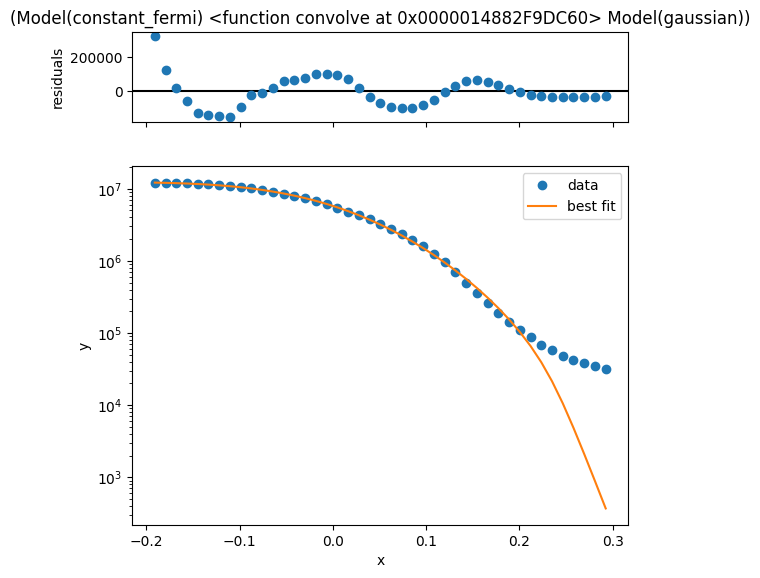

In [70]:
data_fit = spectrum_pret0.loc[{"axis_Energy": slice(-.2, .3)}]
result = model.fit(data_fit, params=pars, x=data_fit.axis_Energy)
lmfit.report_fit(result)
result.plot()
plt.yscale('log')

In [75]:
result.params["T"].stderr

<Parameter 'T', value=151.43724598265612 +/- 24.1, bounds=[-inf:inf]>

In [80]:
temperatures = []
temperature_errors = []
params_list = []
for delay in data.axis_pump_probe_delay:
    data_fit = data.loc[{"axis_angle": slice(0, 10), "axis_Energy": slice(-.2, .3), "axis_pump_probe_delay":delay}].mean(axis=0)
    result = model.fit(data_fit, params=pars, x=data_fit.axis_Energy)
    temperatures.append(result.params["T"].value)
    temperature_errors.append(result.params["T"].stderr)
    params_list.append(result.params)
    pars = pars.update(result.params)
    lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 43
    # variables        = 3
    chi-square         = 4.5095e+11
    reduced chi-square = 1.1274e+10
    Akaike info crit   = 998.157015
    Bayesian info crit = 1003.44062
    R-squared          = 0.99950062
[[Variables]]
    mu:    -0.00511763 +/- 9.5845e-04 (18.73%) (init = -0.007407536)
    T:      112.861345 +/- 35.9889868 (31.89%) (init = 150)
    const:  12339360.3 +/- 65518.5626 (0.53%) (init = 1.236514e+07)
    fwhm:   0.1445778 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, const) = -0.8431
    C(T, const)  = +0.7496
    C(mu, T)     = -0.6333
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 43
    # variables        = 3
    chi-square         = 3.8522e+11
    reduced chi-square = 9.6306e+09
    Akaike info crit   = 991.383380
    Bayesian info crit = 996.666981
    R-squared          = 0.99

(-200.0, 1000.0)

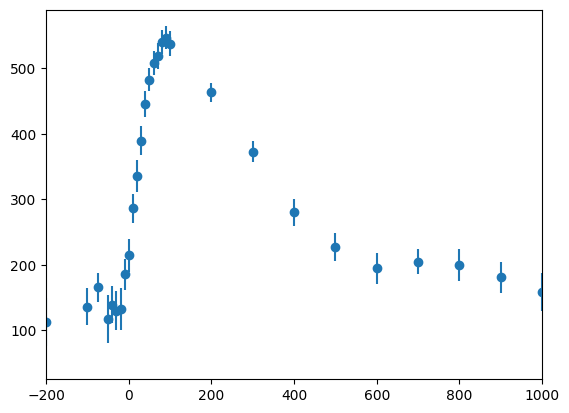

In [83]:
plt.errorbar(data.axis_pump_probe_delay, temperatures, temperature_errors, fmt="o")
plt.xlim((-200, 1000))

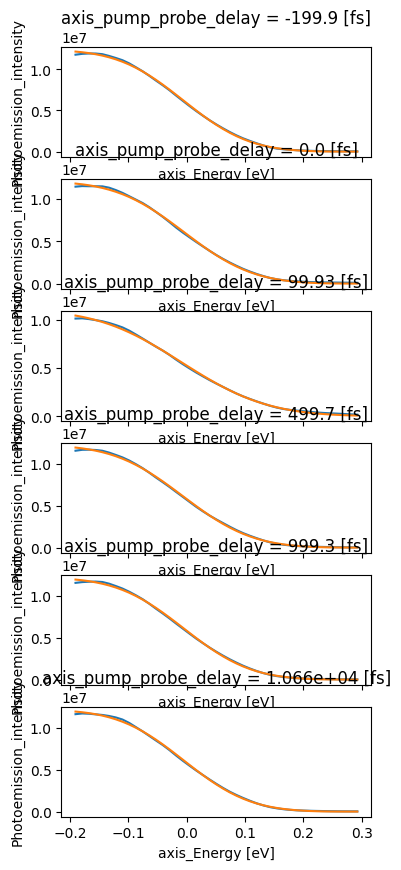

In [98]:
fix, ax = plt.subplots(6, 1, sharex=True, figsize=(4, 10))
for i, delay in enumerate((-200, 0, 100, 500, 1000, 10000)):
    index = np.argmin(np.abs(data.axis_pump_probe_delay.values-delay))
    data_fit = data[{"axis_pump_probe_delay": index}].loc[{"axis_angle": slice(0, 10), "axis_Energy": slice(-.2, .3)}].mean(axis=(0))
    data_fit.plot(ax=ax[i])
    fit = model.eval(params_list[index], x=data_fit.axis_Energy)
    ax[i].plot(data_fit.axis_Energy, fit)